In [1]:
import os
import glob

import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import seaborn as sns

from helper_functions import chessboard_images, extract_corners
from calibration import init_camera_matrix, init_camera_extrinsics


In [2]:
pattern_size=(5, 8)
images = chessboard_images('/workspace/test_images')

['/workspace/test_images/Ladybug1.jpg', '/workspace/test_images/Ladybug2.jpg', '/workspace/test_images/Ladybug3.jpg', '/workspace/test_images/Ladybug4.jpg']


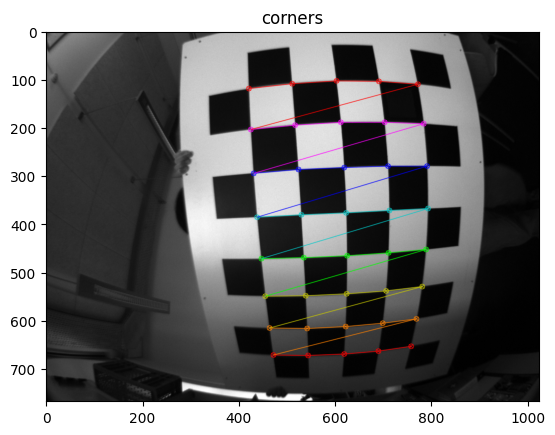

In [3]:
# Test corner extraction
image = cv.imread('/workspace/test_images/Ladybug2.jpg')
corners = extract_corners(image, pattern_size)

if corners is not None:
    cv.drawChessboardCorners(image, pattern_size, corners, True)       
    plt.title('corners')
    plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    plt.show()

In [4]:
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
image_size = (images[-1].shape[0], images[-1].shape[1])
_objpoints = np.zeros((pattern_size[0] * pattern_size[1] ,3), np.float32)
_objpoints[:,:2] = np.mgrid[:pattern_size[0],:pattern_size[1]].T.reshape(-1,2)
for img in images:
    corners = extract_corners(img, pattern_size)
    if corners is not None:
        objpoints.append(_objpoints)
        imgpoints.append(corners)

In [5]:
_mtx = init_camera_matrix(objpoints, imgpoints, skewless=True)

In [6]:
mtx = cv.initCameraMatrix2D(objpoints, imgpoints, image_size)

In [7]:
print(f'\nground truth K = {mtx}')
print(f'\nmy K = {_mtx}')
print(f'\nDiff = {_mtx - mtx}')


ground truth K = [[1.00799532e+03 0.00000000e+00 3.83500000e+02]
 [0.00000000e+00 1.00799532e+03 5.11500000e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

my K = [[495.28921194   0.         629.50514477]
 [  0.         492.80773239 398.56872111]
 [  0.           0.           1.        ]]

Diff = [[-512.70611268    0.          246.00514477]
 [   0.         -515.18759222 -112.93127889]
 [   0.            0.            0.        ]]


In [8]:
_rvecs, _tvecs = init_camera_extrinsics(objpoints, imgpoints)

In [9]:
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, image_size, None, 4, None, None, cv.CALIB_ZERO_TANGENT_DIST+cv.CALIB_FIX_K3,
                                                   criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 2e-16))

In [10]:
import random
def random_color():
        rgbl=[255,0,0]
        random.shuffle(rgbl)
        return tuple(rgbl)

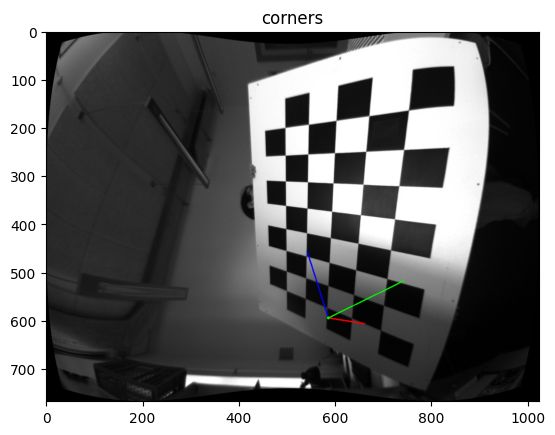

In [11]:
i = 0
img = images[i] 
h,  w = img.shape[:2]
newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

# undistort
mapx, mapy = cv.initUndistortRectifyMap(mtx, dist, None, newcameramtx, (w,h), 5)
dst = cv.remap(img, mapx, mapy, cv.INTER_LINEAR)

# project point
object_points = np.array([(0,0,0), (3,0,0), (0,3,0), (0,0,3)], dtype=float)
image_points, jac = cv.projectPoints(object_points, _rvecs[i], _tvecs[i], newcameramtx, np.zeros([1, 14]))
image_points = np.int32(image_points).reshape(-1,2)

for img_point in image_points[1:]:
    dst = cv.line(dst, tuple(image_points[0]), tuple(img_point), random_color(), 2)
dst = cv.circle(dst, tuple(image_points[0]), 3, (0, 255, 0), -1)

# if show:
#     plt.title(self._images_path[i])
#     plt.imshow(cv.cvtColor(dst, cv.COLOR_BGR2RGB))
#     # as opencv loads in BGR format by default, we want to show it in RGB.
#     plt.show()     
plt.title('corners')
plt.imshow(cv.cvtColor(dst, cv.COLOR_BGR2RGB))
plt.show()